# How-To


*   Run each cell after another, starting from the top
*   Hand in your CMEMS credentials 
*   Customize Route and algorithm parameters along the respective widget cell


# Initialization
- Installing and loading packages
- Clone GitHub repository
- Hand in CMEMS credentials
- Make route settings
  - Route start and end point (Geographic coordinates)
  - Start and end time of route
  - Genetic algorithm settings (generations, population, offspring)
  - Area of Interest (Geographi coordinates Boundingbox)
  - Draft of the ship

In [ ]:
%%capture
!pip install pymoo
!pip install ipywidgets

In [ ]:
%%capture
!git clone https://github.com/jsten07/cms_routing.git

In [ ]:
#@title
import ipywidgets as widgets
from ipywidgets import HBox, VBox

lon_st = widgets.FloatText(value=-73, description='Longitude start:', step = 0.1)
lat_st = widgets.FloatText(value=40.7,description='Latitude start:', step = 0.1)
lon_de = widgets.FloatText(value=-10,description='Longituted end:', step = 0.1)
lat_de = widgets.FloatText(value=38.7,description='Latitude end:', step = 0.1)
stTime = widgets.Text(value="20.06.2021 12:00", description='startTime:')
eTime = widgets.Text(value="30.06.2021 12:00", description='endTime:')
generation_count = widgets.IntText(value=50, description='generations:')
pop_size = widgets.IntText(value=20, description='population:')
offspring = widgets.IntText(value=10, description='offspring:')
lon_min = widgets.IntText(value=-80, description='lon_min:')
lon_max = widgets.IntText(value=0, description='lon_max')
lat_min = widgets.IntText(value=10, description='lat_min')
lat_max = widgets.IntText(value=60, description='lat_max')
draft = widgets.FloatSlider(value=12, steps=0.1, min=6.6, max=16, description='draft')

In [ ]:
#@title
list_widgets  = [
    widgets.VBox([lon_st, lat_st, lon_de, lat_de]),
    widgets.VBox([stTime, eTime]),
    widgets.VBox([pop_size, offspring, generation_count]),
    widgets.VBox([lon_min, lon_max, lat_min, lat_max]),
    widgets.VBox([draft])
    ]
                
accordion = widgets.Accordion(children=list_widgets)
accordion.set_title(0, 'Route Definition:')
accordion.set_title(1, 'Start and End Time:')
accordion.set_title(2, 'Algorithm Settings:')
accordion.set_title(3, 'Area of Interest:')
accordion.set_title(4, 'Ship Parameter:')
accordion

Accordion(children=(VBox(children=(FloatText(value=-73.0, description='Longitude start:', step=0.1), FloatText…

In [ ]:
#@title
%cd cms_routing/scripts
from prediction import get_cmems
from prediction import prepare_grid
from prediction import calculateTimeGrid

/content/cms_routing/scripts


In [ ]:
from getpass import getpass
## input CMEMS credentials
UN_CMEMS = input('Please input your CMEMS username: ')
PW_CMEMS = getpass('Please input your CMEMS password: ')

Please input your CMEMS username: jstenkamp
Please input your CMEMS password: ··········


In [ ]:
#@title
lon_s = lon_st.value
lat_s = lat_st.value
lon_d = lon_de.value
lat_d = lat_de.value

AOI = [lon_min.value, lon_max.value, lat_min.value, lat_max.value] # lon_min, lon_max, lat_min, lat_max

startTime=stTime.value
endTime=eTime.value

# Prepare data
- Download CMEMS data (takes some time)
- Prepare grids to calculate the routes on 

In [ ]:
%cd ..
(ds_w, ds_p) = get_cmems(startTime, endTime, UN_CMEMS, PW_CMEMS)
%cd cms_routing/scripts

/content
[Errno 2] No such file or directory: 'scripts'
/content


In [ ]:
#@title
from joblib import load
model = load("/content/cms_routing/models/DTR_model.joblib")
SOG_N = prepare_grid(ds_w, ds_p, draft.value, "N", model)
SOG_E = prepare_grid(ds_w, ds_p, draft.value, "E", model)
SOG_S = prepare_grid(ds_w, ds_p, draft.value, "S", model)
SOG_W = prepare_grid(ds_w, ds_p, draft.value, "W", model)

In [ ]:
#@title
import xarray as xr
import numpy as np
def get_closest(array, value):
    return np.abs(array - value).argmin()

ds = xr.open_dataset(xr.backends.NetCDF4DataStore(ds_w))

start_lon = get_closest(ds.longitude.data, lon_s)
start_lat = ds.sizes["latitude"]-get_closest(ds.latitude.data, lat_s)
dest_lon = get_closest(ds.longitude.data, lon_d)
dest_lat = ds.sizes["latitude"]-get_closest(ds.latitude.data, lat_d)

AOI = [get_closest(ds.longitude.data, AOI[0]),get_closest(ds.longitude.data, AOI[1]), 2041 - get_closest(ds.latitude.data, AOI[3]), 2041 - get_closest(ds.latitude.data, AOI[2])]

startpoint = (start_lat-AOI[2], start_lon-AOI[0])
endpoint = (dest_lat-AOI[2], dest_lon-AOI[0])

In [ ]:
timeGrids= calculateTimeGrid(SOG_E, SOG_N, SOG_S, SOG_W, AOI)

In [ ]:
#@title
from skimage.graph import route_through_array
from calculate_objectives import calculateTime


def predictNeededTime(startPoint, endPoint, timeGrid):

   route, weight = route_through_array(timeGrid, startPoint, endPoint, fully_connected=False, geometric=True)
   time = calculateTime(route, timeGrid)
   return(time)

time = predictNeededTime(startpoint, endpoint, timeGrids[1])
print(time)

IndexError: ignored

# Run Algorithm
- Run NSGA II algorithm 
- Measure time needed to run the algorithm

In [ ]:
from runAlgorithm import runAlgorithm
from time import process_time

t_start = process_time()
res = runAlgorithm(startpoint, endpoint, startTime, endTime, timeGrids[1], population=pop_size.value, offspring=offspring.value, generations=20)
t_stop = process_time()
time_lr = t_stop-t_start
print("Elapsed time in seconds: ", time_lr)

# name: MyProblem
# n_var: 2
# n_obj: 2
# n_constr: 0



/usr/local/lib/python3.7/dist-packages/pymoo/model/population.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = [np.array(e) for e in res]


n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      21 |       2 |            - |            -


/content/cms_routing/scripts/spatial_crossover.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([[parent1_index, child_1], [parent2_index, child_2]])
/content/cms_routing/scripts/spatial_mutation.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  offspring = np.array(offspring)


    2 |      31 |       2 |  0.00000E+00 |            f
    3 |      41 |       2 |  0.00000E+00 |            f
    4 |      51 |       2 |  0.223051999 |        ideal
    5 |      61 |       2 |  0.055659782 |        ideal
    6 |      71 |       2 |  0.00000E+00 |            f
    7 |      81 |       3 |  0.101406784 |            f
    8 |      91 |       4 |  0.003465596 |            f
    9 |     101 |       4 |  0.00000E+00 |            f
   10 |     111 |       4 |  0.00000E+00 |            f
   11 |     121 |       4 |  0.00000E+00 |            f
   12 |     131 |       4 |  0.00000E+00 |            f
   13 |     141 |       4 |  0.00000E+00 |            f
   14 |     151 |       5 |  0.000415459 |            f
   15 |     161 |       6 |  0.013583113 |            f
   16 |     171 |       7 |  0.000208679 |            f
   17 |     181 |       7 |  0.00000E+00 |            f
   18 |     191 |       9 |  0.015382159 |            f
   19 |     201 |      10 |  0.002568033 |      

In [ ]:
np.save("./routes_simple_20g_10d_40pop",res.X)
np.save("./values_simple_20g_10d_40pop",res.F)

In [ ]:
results = res.F
routes = res.X

In [ ]:
# Visualization
- Show routes on map
  - Best in-time route
  - Most energy efficient route (least fuel use)
- Plot pareto front
- Plot pareto fronts over generations

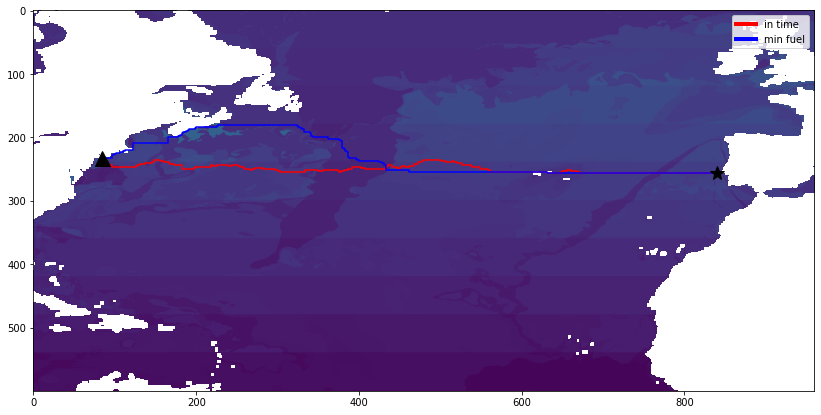

In [ ]:
#@title
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors
from matplotlib.lines import Line2D
route_minTime = routes[np.argmin(results[:,0], axis=0)][1]
route_minfuelUSe = routes[np.argmin(results[:,1], axis=0)][1]

route_minTime_Display =   np.stack(route_minTime, axis=-1)
route_minfuelUSe_Display =   np.stack(route_minfuelUSe, axis=-1)

# timeGridsDisplay= np.where(timeGrids[1][2] > 999, np.nan, timeGrids[1][2])

plt.figure(figsize=(14,7))
from matplotlib import cm

timeGrid = np.where(timeGrids[1][2] > 999, np.nan, timeGrids[1][2])
# Costs
im = plt.imshow(timeGrid, aspect='auto', vmax=80);
# Route
plt.plot(route_minTime_Display[1],route_minTime_Display[0], 'r')
plt.plot(route_minfuelUSe_Display[1],route_minfuelUSe_Display[0], 'b')
# Start/end points
plt.plot(startpoint[1], startpoint[0], 'k^', markersize=15)
plt.plot(endpoint[1], endpoint[0], 'k*', markersize=15)
# plt.colorbar(im, ax=plt, orientation='horizontal', label='time per grid cell', shrink=0.8);

custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4)]
plt.legend(custom_lines, ['in time', 'min fuel'])

[-500.0, 0.0, 500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0]


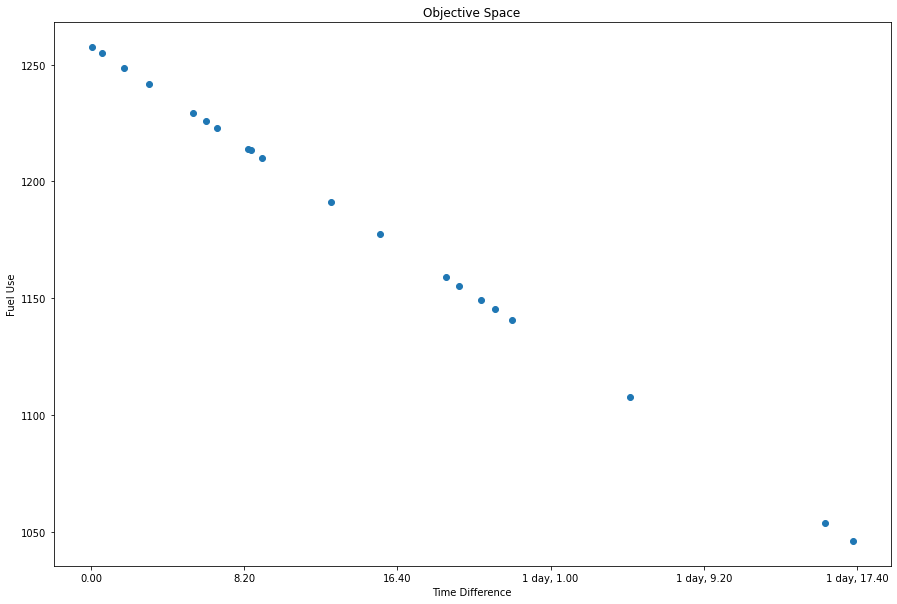

In [ ]:
#@title
import math
from datetime import time, timedelta
# Pareto Front
def transformTick(timeDifference):
    td = timedelta(minutes=timeDifference)
    return ".".join(str(td).split(':')[:2])
    

timeDiffs= results[:,0]
timeDiff = np.array([math.sqrt(x) for x in timeDiffs])

f1, ax1 = plt.subplots(1, figsize=(15,10))
plt.scatter(timeDiff,results[:,1])
a= ax1.get_xticks().tolist()
print(a)
result= map(transformTick, a)
ax1.set_xticklabels(result)
ax1.set_title("Objective Space")
ax1.set_xlabel('Time Difference')
ax1.set_ylabel('Fuel Use')
#plt.savefig(default_directory+"/results2016N6/pareto_front.png")
plt.show()

In [ ]:
#@title
# Create an empty list to save objective values per generation
# Needed for history 
f = []
# iterate over the generations
for generation in res.history:
 # retrieve the optimal for all objectives from the generation
 opt = generation.opt
 this_f = opt.get("F")
 f.append(this_f)

fNumpy = np.asarray(f)
history = fNumpy

In [ ]:
#@title
# add here the generations you want to see in the plot
generations2plot = [math.floor(generation_count.value*0.2), math.floor(generation_count.value*0.4), math.floor(generation_count.value*0.6), math.floor(generation_count.value*0.8),generation_count.value]
# make the plot
fig4, ax4 = plt.subplots(1)
# i - 1, because generation 1 has index 0
for i in generations2plot:
 plt.scatter(history[i-1][:,0],history[i-1][:,1])

plt.legend(generations2plot)
plt.show()